### **📝 Client Request: American Option Purchase**

A client has requested that the bank **purchase an American put option** on **Commonwealth Bank of Australia (CBA)** with the following details:

- **Option Type**: American Put  
- **Underlying Asset**: Commonwealth Bank of Australia (CBA)  
- **Strike Price**: $170.00  
- **Expiry Date**: 15 May 2026

To solve this problem, binomial tree method was applied to value the American put option on CBA shares. This model simulates potential future price movements of the stock over discrete time intervals until the option’s expiry on 15 May 2026. Using the Cox-Ross-Rubinstein framework, the model incorporates early exercise features and the time value of money to determine the fair premium the bank should pay for the option with a strike price of $170.00.

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import datetime

In [101]:
def get_CBA_data():
    
    valuation_date = datetime.datetime(2025, 5, 16)
    valuation_end_date = datetime.datetime(2026, 5, 15)
    lookback_start = datetime.datetime(2024, 5, 16)

    ticker = yf.Ticker('CBA.AX')
    hist_vol = ticker.history(start=lookback_start, end=valuation_date)
    if hist_vol.empty:
        raise ValueError("No historical data available for volatility calculation.")
    
    # including period of 1 year to calculate historical volatility
    ticker = yf.Ticker("CBA.AX")
    hist_vol = ticker.history(start=lookback_start, end=valuation_date)
    if hist_vol.empty:
        raise ValueError("No historical data available for volatility calculation.")
    
    # calculating annualized historical volatility assuming 252 trading days in a year
    hist_vol['log_return'] = np.log(hist_vol['Close'] / hist_vol['Close'].shift(1))
    hist_vol = hist_vol.dropna()
    daily_vol = hist_vol['log_return'].std()
    average_daily_vol = hist_vol['log_return'].abs().mean()
    annual_vol = daily_vol * np.sqrt(252)

    hist = yf.download('CBA.AX', start='2025-05-16', end='2025-05-17')
    if hist.empty:
        raise ValueError("No price data available for 16 May 2025.")
    S0 = hist['Close'].iloc[0]
   
    try:
        info = ticker.info
        dividend_yield = (info.get("dividendYield", 0.0) or 0.0)/100  # annual dividend yield
    except:
        dividend_yield = 0.0

    r = 0.0367  # risk-free rate, assumed constant for simplicity


The following function prices an American put option by implementing the Cox-Ross-Rubinstein (CRR) binomial tree model, which accounts for continuous dividend yield.

#### Parameters:

- **S0** (*float*): Spot price of the underlying asset  
- **K** (*float*): Strike price of the option  
- **r** (*float*): Risk-free interest rate (annualised)  
- **q** (*float*): Continuous dividend yield (annualised)  
- **T** (*float*): Time to expiry, expressed in years  
- **sigma** (*float*): Volatility of the underlying asset (annualised)  
- **N** (*int*): Number of steps in the binomial tree  

#### Returns:

- **float**: The calculated premium (price) of the American put option

In [102]:
def binomial_american_put(S0, K, r, q, T, sigma, N):
    
    #calculating time step
    dt = T/N
    print(f"dt: {dt}")

    #calculating up and down factors
    u = np.exp(sigma*np.sqrt(dt))
    print(f"u: {u}")
    d = 1/u
    print(f"d: {d}")

    #calculating risk-neutral probabilities
    p = (np.exp((r-q)*dt)-d)/(u-d)
    print(f"p: {p}")
    disc = np.exp(-r*dt)

    # Build stock tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            stock_tree[i, j] = S0*(u**j)*(d**(i-j))

    # Build option tree
    option_tree = np.zeros((N+1, N+1))
    for j in range(N+1):
        option_tree[N, j] = max(K-stock_tree[N, j], 0)

    # Backward induction
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            hold = disc * (p*option_tree[i+1, j+1]+(1-p)*option_tree[i+1, j])
            exercise = max(K - stock_tree[i, j], 0)
            option_tree[i, j] = max(hold, exercise)

    # Return the option price at time 0
    return option_tree[0, 0], stock_tree, option_tree

dt: 0.19945205479452055
u: 1.101064280881146
d: 0.9082121883017878
p: 0.4871309112351265
American Put Option Price: $14.36


C:\Users\marce\AppData\Local\Temp\ipykernel_22680\1644039432.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_tree[i, j] = S0*(u**j)*(d**(i-j))


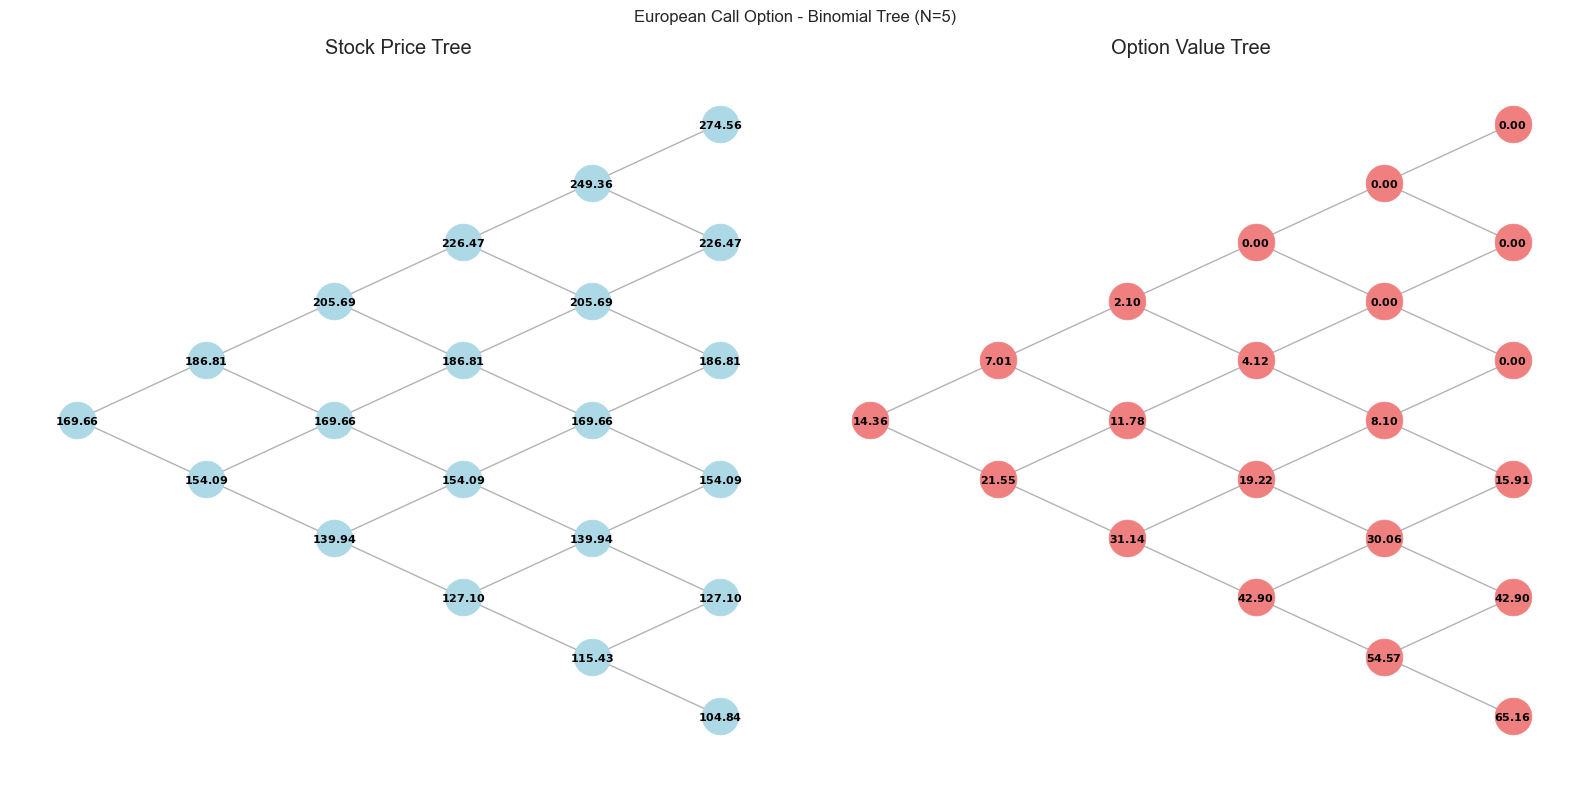

In [105]:
import seaborn as sns

plt.style.use('ggplot')
sns.set_style("whitegrid") # the seaborn library is being used to set the style of the plots
plt.rcParams['figure.figsize'] = (12, 8)

# Use S0_value (float) and ensure N is an integer
K = 170
T = (valuation_end_date - valuation_date).days / 365.0
q = dividend_yield
sigma = annual_vol
N = 5
#int(T * 100)  # Use 100 steps per year for better accuracy

put_price, stock_tree, option_tree = binomial_american_put(S0, K, r, q, T, sigma, N)
print(f"American Put Option Price: ${put_price:.2f}")

from Put_option_visualistation import plot_binomial_tree

plot_binomial_tree(stock_tree, option_tree, N)